In [3]:
# run this cell if working in google colab environment  
# import os 

# !git clone https://github.com/mchirib1/Basics-of-Forster-Resonance-Energy-Transfer.git
# os.chdir('/content/Basics-of-Forster-Resonance-Energy-Transfer')
# print(os.getcwd())

In [4]:
# for generating data
import random

# for linear algebra
import numpy as np

# for visualizing data
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# for creating data frames
import pandas as pd

# Concept Outline
The goal of this notebook is to show how to apply the central equations of Förster Resonance Energy Transfer (FRET) theory. Generally FRET systems are described by their Förster Distance ($R_{0}$) or the distance at which energy transfer is $50\%$ efficient. The $R_{0}$ for a donor-acceptor pair can be calculated in $nm$ using the following equation:

$$R_{0}=(\frac{9ln(10)}{128\pi^{5}N_{A}}*\frac{\kappa^{2}\Phi_{D}}{n^{4}}*10^{17}*J_{\lambda})^{\frac{1}{6}}$$

The final term in the equation, $J$, is known as the "J overlap" or "spectral overlap" integral and can be described as:

$$J_{\lambda}=\int_{\lambda}^{\lambda + \Delta\lambda}F_{D}(\lambda)\epsilon_{A}(\lambda)\lambda^{4}d\lambda$$

FRET is often used as a "molecular ruler" and a crucial component of this experimental design is that FRET is that the efficiency of energy transfer ($EE_{T}$) can be estimated at an arbitrary donor-acceptor separation distance ($r_{da}$) according to the equation:

$$EE_{T} = \frac{1}{1+(\frac{r_{da}}{R_{0}})^{6}}$$

This way if the $EE_{T}$, which can be measured using fluorescence spectroscopy, is known the distance separating the donor and acceptor can be accurately estimated. Here I'll outline the necessary steps and concepts to enable calculation of $R_{0}$. For data I use "stand-in data" from ThermoFisher's AlexaFluor dye series. These are common commercially available dyes often used for FRET transfer relays. However, any experimentally obtained component absorbance and emission spectra can be used, assuming the dyes are in a pure state.

# Data Collection
The stand-in data was taken from the ThermoFisher [Spectra Viewer](https://www.thermofisher.com/order/fluorescence-spectraviewer#!/) tool. 

In this example we will estimate the $R_{0}$ for transfer from an AlexaFluor488 donor to an AlexaFluor594 acceptor. To download alternative  data go to the url and export the spreadsheets. The cell below reads in the data and plot spectra of both the donor and acceptor. 

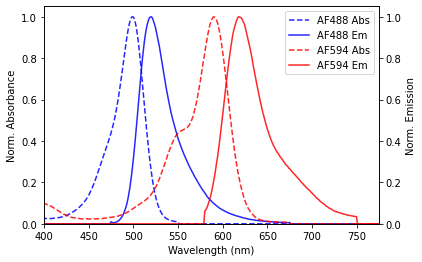

In [6]:
# functions for plotting spectra
def plot_spectra(ax, x, y1, y2, y3, y4):
    
    ax2 = ax.twinx()
    
    ax.plot(x, y1, '--b', alpha=0.85, label='AF488 Abs')
    ax.plot(x, y2, '-b', alpha=0.85, label='AF488 Em')
    
    ax.plot(x, y3, '--r', alpha=0.85, label='AF594 Abs')
    ax.plot(x, y4, '-r', alpha=0.85, label='AF594 Em')

    ax2.set_ylabel('Norm. Emission')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Norm. Absorbance')
     
    ax.set_xlim(400, 775)
    ax.set_ylim(0)
    ax2.set_ylim(0, ax.get_ylim()[1] )
    
    ax.legend()
    
    return ax

# Once the data has been downloaded read the data in here
donor = pd.read_csv('Alexa Fluor 488.csv', index_col='Wavelength')
acceptor = pd.read_csv('Alexa Fluor 594.csv', index_col='Wavelength')

# the wavelength is usually plotted along the x-axis
x = donor.index.values

# experimentally obtained data can be used as long as spectral peak shapes remain constant 
# in order to determine this simply normalize the data to its peak max
absorbance_donor = (donor['Excitation'] / donor['Excitation'].max()).values
emission_donor = (donor['Emission'] / donor['Emission'].max()).values

absorbance_acceptor = (acceptor['Excitation'] / acceptor['Excitation'].max()).values
emission_acceptor = (acceptor['Emission'] / acceptor['Emission'].max()).values

# plot the absorbance and emission spectra
ax = plt.axes()
plot_spectra(ax, x,absorbance_donor, emission_donor, absorbance_acceptor, emission_acceptor)
plt.show()

# Introduction to photophysical constants
In addition to the absorbance and emission spectra, photophysical constants need to be defined.

But first we refer to the equation which describes the $R_{0}$ in terms of $nm$:
$$R_{0}=(\frac{9ln(10)}{128\pi^{5}N_{A}}*\frac{\kappa^{2}\Phi_{D}}{n^{4}}*10^{17}*J)^{\frac{1}{6}}$$

In this equation there are 5 variables which need to be defined:

1. Avogadro's number ($N_{A}$) where $N_{A} = 6.02*10^{23}$
2. The dipole orientation factor ($\kappa^{2}$) where $0 \le \kappa^{2} \le 4$ (often assumed to be $\frac{2}{3}$ for fully solvated fluorophores)
3. The quantum yield of the donor ($\Phi_{D}$) where $0 \le \Phi_{D} \le 1$
4. The refractive index of the measurement medium ($n$) where $n = 1.33$ for aqueous solutions
5. The spectral overlap integral or $J_{\lambda}$ which is defined as:
    
    $$J_{\lambda}=\int_{\lambda}^{\lambda + \Delta\lambda}F_{D}(\lambda)\epsilon_{A}(\lambda)\lambda^{4}d\lambda$$
    
    Within the J overlap integral there are a couple more variables to define:

    1. The exctinction coefficient of the acceptor ($\epsilon_{A}$) which is specific to a dye species 
    2. The donor emission normalized to total unity ($F_{D}$)
    3. $\lambda$ which simply refers to the wavelength in terms of $nm$
    
In the cells below each variable is individually defined for clarity. Variables can be substituted in to tailor the equations to any specific dye system.

# Avogadro's Constant 

Avogadro's constant ($N_{A}$) is the number of particles per mole and is generally assumed to be $N_{A} = 6.02*10^{23} mol^{-1}$. 

However, sometimes confusion may arise in that Förster occasionally used $N'$ such that $N' = 6.02*10^{20} mmol^{-1}$. For example, in Förster's [1948 publication](https://onlinelibrary.wiley.com/doi/abs/10.1002/andp.19484370105), he used $9000ln(10)$ and $N'$. Although both $N'$ and $N_{A}$ represent equivalent amounts of particles per mole, careful consideration must be paid when normalizing units.   

Here we assume the former value of $N_{A}$.

In [7]:
Na = 6.02E23

# Refractive index
The refractive index ($n$) refers to the medium we are measuring in. Here we assume measurement is in aqueous solution and the refractive index will be assumed constant such that $n = 1.33$.

In [8]:
n = 1.33

# Kappa Squared
The kappa squared ($\kappa^{2}$) for a given donor-acceptor pair can be complicated to calcluate. As a generalization, the $\kappa^{2}$ describes the relative orientations of the donor emission transition moment, the acceptor absorbance transition moment, and the center-to-center line that connects the donor and accpetor ($r$), where the donor and acceptor are treated as 1D point dipoles oriented in 3D space. 

In the cell below you can see the 2D representation of some important edge case dipole alignments. For example parallel oriented dipoles typically assume a value of $\kappa^{2} = 1$, dipoles oriented perpendicularly assume a value of $\kappa^{2} = 0$, and dipoles oriented in linear alignment assume a value of $\kappa^{2} = 4$.

Mathematically, the $\kappa^{2}$ can be described by the equation:

$$\kappa^{2} = (cos\theta_{T} - 3 cos\theta_{D} * cos\theta_{A})^2$$ 

But in practice we can also compute the $\kappa^{2}$ as the dot product between vectors which is what was used to calculate the $\kappa^{2}$ in the plots below: 

$$\kappa^{2} = (\vec{a} \cdot \vec{d} - 3 (\vec{a} \cdot \vec{r})(\vec{r} \cdot \vec{d}))^2$$ 

However, the $\kappa^{2}$ is not really possible to be measured experimentally. In general, for most basic FRET calculations, the assumption $\kappa^{2} = \frac{2}{3}$ is made. This is based on the random dynaimc averaging of fully solvated fluorophores. This is the constant which will be assumed for our $R_{0}$ calculation below.

In [10]:
def unit_circle(center_x, center_y):
    
    angle = np.linspace(0, 2 * np.pi, 150)
    
    radius = 1
    
    x = radius * np.cos(angle) + center_x
    y = radius * np.sin(angle) + center_y
    
    return x, y


def random_unit_vector(center_x, center_y):
    
    n = random.uniform(0,2)
    
    x_0 = 0 + center_x
    y_0 = 0 + center_y
    x_1 = np.cos(n * np.pi)  
    y_1 = np.sin(n * np.pi)  
    
    return x_0, y_0, x_1, y_1


def defined_unit_vector(center_x, center_y, n1, n2):
    
    n = random.uniform(0,2)
    
    x_0 = 0 + center_x
    y_0 = 0 + center_y
    x_1 = np.cos(n1 * np.pi)  
    y_1 = np.sin(n2 * np.pi)  
    
    return x_0, y_0, x_1, y_1


def kappa_squared(dv, rv, av):
    
    k = (np.dot(dv, av) - 3 * np.dot(dv, rv) * np.dot(rv, av))
    k = k ** 2 
    
    return k

In [11]:
k = (2/3)

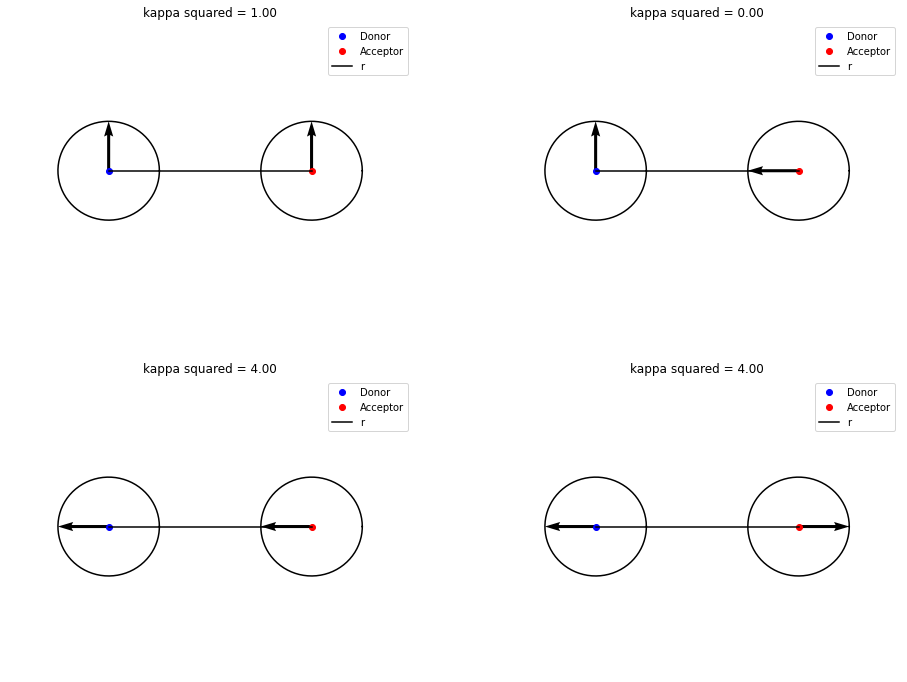

In [12]:
fig, ax = plt.subplots(2, 2, figsize = (16,12))
ax = ax.reshape(4)

# define edge case vectors to iterate.
dvectors = np.array([[0.5, 0.5], [0.5, 0.5], [1, 1], [1, 1]])
avectors = np.array([[0.5, 0.5], [1, 1], [1, 1], [0, 0]])

for i, j in enumerate(ax):
    
    # shift the unit circles centers for the donor and acceptor
    centerxd = -2
    centeryd = 0

    centerxa = 2
    centerya = 0

    # calculate the donor position and a random unit vector dipole moment
    xd, yd = unit_circle(centerxd, centeryd)
    x_0d, y_0d, x_1d, y_1d = defined_unit_vector(centerxd, centeryd, dvectors[i][0], dvectors[i][1])

    # calculate the acceptor position and a random unit vector dipole moment
    xa, ya = unit_circle(centerxa, centerya)
    x_0a, y_0a, x_1a, y_1a = defined_unit_vector(centerxa, centerya, avectors[i][0], avectors[i][1])

    # plot the two dipole moments 
    ### Note: each vector needs x,y coordinates for both the head and the tail
    ax[i].quiver(x_0d, y_0d, x_1d, y_1d, angles='xy', scale_units='xy', scale=1)
    ax[i].quiver(x_0a, y_0a, x_1a, y_1a, angles='xy', scale_units='xy', scale=1)

    # plot the donor and acceptor center coordinates
    ax[i].plot(xd, yd, c='k')
    ax[i].plot(x_0d, y_0d, 'ob', label='Donor')
    ax[i].plot(xa, ya, c='k')
    ax[i].plot(x_0a, y_0a, 'or', label='Acceptor')

    # plot the center-to-center vector
    ax[i].plot(np.linspace(x_0d, x_0a), np.zeros(50), c='k', label='r')

    # format axes
    ax[i].legend()
    ax[i].set_xlim(-4,4)
    ax[i].set_ylim(-3,3)
    ax[i].grid(False)
    ax[i].axis(False)

    # define vectors for kappa squared calculation
    dv = [x_1d, y_1d] 
    rv = [1, 0]
    av = [x_1a, y_1a]
    title = f'kappa squared = {kappa_squared(dv, rv, av):0.2f}'
    ax[i].set_title(title)    

Run the cell below to plot an example of a donor-acceptor pair along with a random unit vector transition moments and a center-to-center connecting line. Though this is not directly comparable to the 3D analog, I think it conveys the idea. Also included is an approximate $\kappa^{2}$:

kappa squared ~0.04


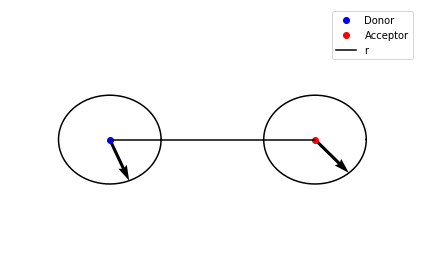

In [14]:
ax = plt.axes()

# shift the unit circles centers for the donor and acceptor
centerxd = -2
centeryd = 0

centerxa = 2
centerya = 0

# calculate the donor position and a random unit vector dipole moment
xd, yd = unit_circle(centerxd, centeryd)
x_0d, y_0d, x_1d, y_1d = random_unit_vector(centerxd, centeryd)

# calculate the acceptor position and a random unit vector dipole moment
xa, ya = unit_circle(centerxa, centerya)
x_0a, y_0a, x_1a, y_1a = random_unit_vector(centerxa, centerya)

# plot the two dipole moments 
### Note: each vector needs x,y coordinates for both the head and the tail
ax.quiver(x_0d, y_0d, x_1d, y_1d, angles='xy', scale_units='xy', scale=1)
ax.quiver(x_0a, y_0a, x_1a, y_1a, angles='xy', scale_units='xy', scale=1)

# plot the donor and acceptor center coordinates
ax.plot(xd, yd, c='k')
ax.plot(x_0d, y_0d, 'ob', label='Donor')
ax.plot(xa, ya, c='k')
ax.plot(x_0a, y_0a, 'or', label='Acceptor')

# plot the center-to-center vector
ax.plot(np.linspace(x_0d, x_0a), np.zeros(50), c='k', label='r')

# format axes
ax.legend()
ax.set_xlim(-4,4)
ax.set_ylim(-3,3)
ax.grid(False)
ax.axis(False)

# define vectors for kappa squared calculation
dv = [x_1d, y_1d] 
rv = [1, 0]
av = [x_1a, y_1a]

print(f'kappa squared ~{kappa_squared(dv, rv, av):0.2f}')

plt.tight_layout()
plt.show() 

The transition moments can also be represented in 3D using python code. However, it is difficult to visualize in a jupyter notebook environment. Therefore a standalone python script for visualizing the 3D kappa sqaured can be found in the directory to be used individually. 

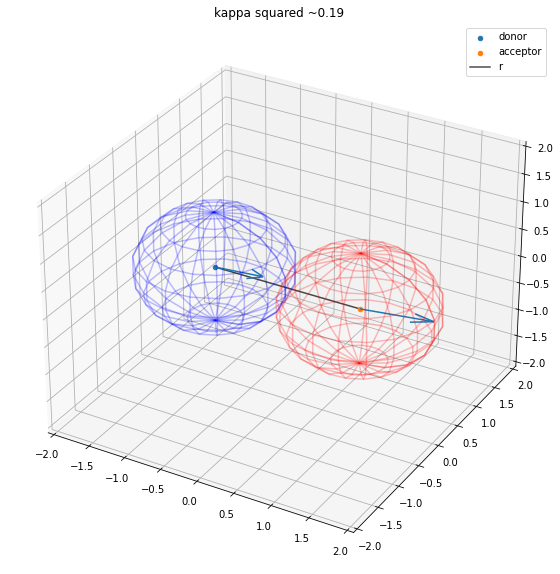

In [16]:
def unit_sphere(center_x, center_y):
   
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    
    r = 1
    
    x = r * np.cos(u) * np.sin(v) + center_x
    y = r * np.sin(u) * np.sin(v) + center_y
    z = r * np.cos(v)
    
    return x, y, z


def transition_vector(center_x, center_y):

    u = np.random.uniform(0, 2) * np.pi
    v = np.random.uniform(0, 1) * np.pi
    
    x = np.cos(u) * np.sin(v) 
    y = np.sin(u) * np.sin(v) 
    z = np.cos(v)
    
    return x, y, z


def l2_norm(vector):
    
    v = vector ** 2
    v = v.sum()
    v = np.sqrt(v)
    
    return v   


def kappa_squared(dv, rv, av):
    
    k = (np.dot(dv, av) - 3 * np.dot(dv, rv) * np.dot(rv, av))
    k = k ** 2 
    
    return k


# initialize axes
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# plot donor center and surface
x, y, z = unit_sphere(-1, 0)
ax.plot_wireframe(x, y, z, color="b", alpha=0.25)
ax.scatter(-1, 0, 0, 'ob', label='donor')

# plot acceptor center and surface 
x, y, z = unit_sphere(1, 0)
ax.plot_wireframe(x, y, z, color="r", alpha=0.25)
ax.scatter(1, 0, 0, 'or', label='acceptor')

#plot vectors
## center-to-center vector "r"
x = np.linspace(-1, 1, 10)
y = np.zeros(10)
z = np.zeros(10)
r_vector = np.array([1, 0, 0])
ax.plot(x, y, z, '-k', label='r', alpha=0.7)

## donor transition 
x, y, z = transition_vector(-1, 0)
d_vector = np.array([x, y, z])
d_norm = l2_norm(d_vector)
ax.quiver(-1, 0, 0, x, y, z)

# acceptor transition
x, y, z = transition_vector(1, 0)
a_vector = np.array([x, y, z])
a_norm = l2_norm(a_vector)
ax.quiver(1, 0, 0, x, y, z)

# format axes
ax.legend()
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

ax.set_title(f'kappa squared ~{kappa_squared(d_vector, r_vector, a_vector):0.2f}')

plt.show()

# Quantum yield and extinction coefficient

[Quantum yield](https://www.thermofisher.com/us/en/home/references/molecular-probes-the-handbook/tables/fluorescence-quantum-yields-and-lifetimes-for-alexa-fluor-dyes.html) and [exctinction coefficient](https://www.thermofisher.com/us/en/home/references/molecular-probes-the-handbook/technical-notes-and-product-highlights/the-alexa-fluor-dye-series.html) data are photophysical constants attributed to individual dye species. These data can be collected from reference guides, handbooks and available literature. However, both of these variables can change based on the behavior dyes or environmental conditions and it is good practice experimentally validate. 

***A quick note on QY and Exctinction...***

***The extinction coefficient refers to how stronly a chemical species will absorb light in solution and is linearly related to absorbance, path length, and concentration through the Beer-Lambert law ($A = c\epsilon l$) where $A$ is absorbance, $l$ is the path length of light through the sample, $\epsilon$ is the exctinction coefficient, and $c$ is the molar concentration of the chemical species. In general reported excinction coefficients generally refer to the wavelength at which the species maximally absorbs.***

***The quantum yield is the fraction of the excited state population which will relax through the emission of a photon and in a sense, describes the brightness of the fluorophore. The quantum yield is environmentally sensitive and will change based on any modifications to the dye or the local environment. This means in many cases it is improper to assume standard values for experimental systems.***

In [17]:
# QY values from reference
qy488 = 0.92
qy594 = 0.66

# extinction values from reference
e488 = 73000
e594 = 92000

# Spectral Overlap Integral

As mentioned above $J_{\lambda}$ can be calculated according to the equation:

$$J_{\lambda}=\int_{\lambda}^{\lambda + \Delta\lambda}F_{D}(\lambda)\epsilon_{A}(\lambda)\lambda^{4}d\lambda$$

However, there are a couple nuances which need to be remembered when plotting or calculating spectral overlap:

1. Donor fluorescence needs to be normalized such that the total emission equals unity. This means that $F_{D}$ is not the raw emisison and the normalized emission can be calculated according to the equation below:

    $$ F_{D} = \frac{I_{D}(\lambda)}{\int I_{D}(\lambda)d\lambda} $$
    
    where $I_{D}(\lambda)$ is the emission intensity at that wavelength. In the cell below we calculate and plot the normalized fluoresence emission spectra.

In [18]:
# calculate total emission
emission_sum = emission_donor.sum()

# normalize to total emission as unity
normalized_emission = emission_donor / emission_sum

# plot vs wavelength 
x = donor.index.values

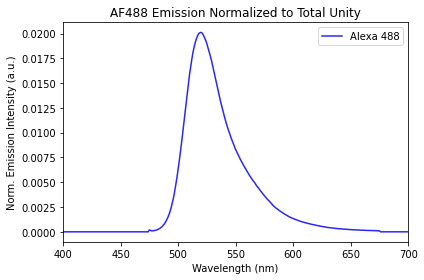

In [20]:
ax = plt.axes()
ax.plot(x, normalized_emission, alpha=0.85, c='b', linestyle='-', label='Alexa 488')

ax.legend()
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Norm. Emission Intensity (a.u.)')

ax.set_xlim(400, 700)
ax.set_title('AF488 Emission Normalized to Total Unity')

plt.tight_layout()
plt.show()

2. The exctinction coefficient also needs to be plotted as a function of wavelength. Here you simply need to min-max normalize the absorbance spectra between 0 and 1 then scale the spectra by the extinction coefficient. It is also important to remember that although absorbance is in arbitraty units, $\epsilon$ is in units of $M^{-1}cm^{-1}$.

   For an example see the cell below.

In [21]:
# scale the absorbance spectra by the the exctinction
extinction_acceptor = absorbance_acceptor * e594 

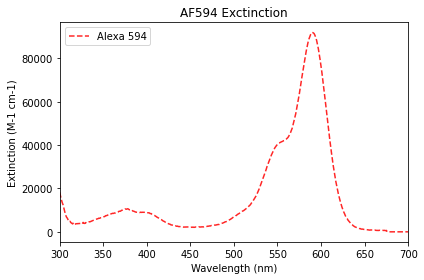

In [23]:
ax = plt.axes()

ax.plot(x, extinction_acceptor, alpha=0.85, c='r', linestyle='--', label='Alexa 594')

ax.set_xlim(300, 700)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Extinction (M-1 cm-1)')

ax.set_title('AF594 Exctinction')
ax.legend()

plt.tight_layout()
plt.show()

In the cell below is a python function defined calculate the full $J_{\lambda}(\lambda)$ incorporating the above normalizations. 

In [24]:
def j_overlap(wavelengths, donor_em, acceptor_abs, e):
    
    # min-max normalize the acceptor absorbance
    acceptor_abs = acceptor_abs / acceptor_abs.max()
    
    # multiply the normalized spectra by the exctinction coefficient to get the extinction at each wavelength (cm-1, M-1)
    acceptor_e = acceptor_abs * e
    
    # integrate the donor emission spectra to get total emission
    donor_sum = donor_em.sum()
    
    # normalize the donor emission to unity
    donor_em = donor_em / donor_sum
    
    wavelengths = wavelengths ** 4
    
    # now to calculate the overlap integral you multiply the constituate components 
    j = donor_em * acceptor_e * wavelengths
    
    return j # (M-1 cm-1, nm4)

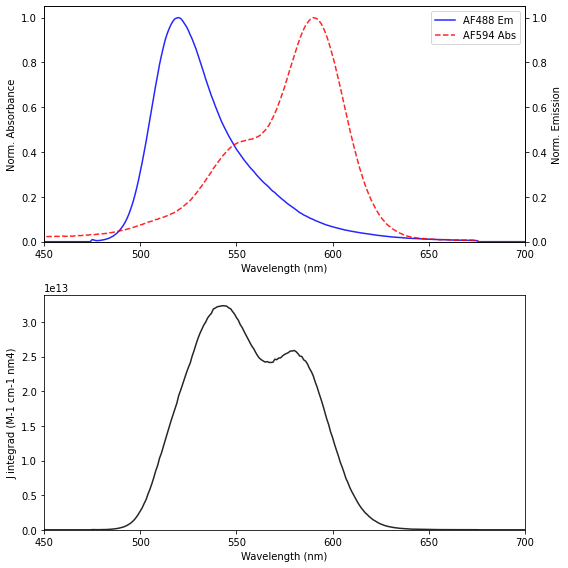

In [26]:
# functions for plotting spectra
def plot_absorbance_emission(ax, x, y1, y2):
    
    ax2 = ax.twinx()
    
    ax.plot(x, y1, '-b', alpha=0.85, label='AF488 Em')
    ax.plot(x, y2, '--r', alpha=0.85, label='AF594 Abs')

    ax2.set_ylabel('Norm. Emission')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Norm. Absorbance')
     
    ax.set_xlim(450, 700)
    ax.set_ylim(0)
    ax2.set_ylim(0, ax.get_ylim()[1] )
    
    ax.legend()
    
    return ax

def plot_j_overlap(ax, x, j):
    
    ax.plot(x, j, '-k', alpha=0.85)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('J integrad (M-1 cm-1 nm4)')
    ax.set_xlim(450, 700)
    ax.set_ylim(0)
    
    return ax

j = j_overlap(x, emission_donor, absorbance_acceptor, e594)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8,8))

plot_absorbance_emission(ax1, x, emission_donor, absorbance_acceptor)
plot_j_overlap(ax2, x, j) 

plt.tight_layout()
plt.show()

# Forster Distance Calculation

Finally we can use each of the above componets to estimate the forster distance between the donor and acceptor. 

In [51]:
def forster_distance(Na, kappa, phi_d, n, J):
    
    # term one mostly constants
    term1 = (9 * np.log(10)) / (128 * np.pi**5 *Na)
    
    # term 2 quantum yield, kappa squared, and refractive index
    term2 = (kappa * phi_d) / (n)
    
    # normalize units to nms
    term3 = 10E17
    
    # integrate the J overlap with sum
    term4 = J.sum()
    
    # multupy each term 
    forster_d_6 = term1 * term2 * term3 * term4 
    
    # finally take the sixth root
    forster_d = np.power(forster_d_6, (1/6))
    
    return forster_d

print(f'The estimated Forster Distance is {forster_distance(Na, k, qy488, n, j):0.2f} nm')

The estimated Forster Distance is 9.97 nm
